# Tasca 7 : Transformació Registre Log amb Regular expressions

Roger Gallart - 30 abril 2021

L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos.

## Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han de normalitzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

### Exercici 1
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
# Descomprimim el fitxer .7z a Google Colab
!apt-get install p7zip-full
!7z e /content/drive/MyDrive/ITAcademy/Data-Science-main/Data-sources/Web_access_log-akumenius.com.txt.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/ITAcademy/Data-Science-main/Data-sources/                                                                          1 file, 2960037 bytes (2891 KiB)

Extracting archive: /content/drive/MyDrive/ITAcademy/Data-Science-main/Data-sources/Web

In [3]:
# Importem el fitxer de log a un DataFrame

# Fitxer de log
fname = "/content/Web_access_log-akumenius.com.txt"

# Patró RegEx per llegir el fitxer de log
# L'he creat manualment amb la pàgina www.regex101.com
pattern = r'(\S+)\s([0-9.]+|-)\s(.+)\s(.+)\s\[(.+)\]\s\"(.+)\"\s(\d+|-)\s(\d+|-)\s\"(.+)\"\s\"(.+)\"\sVLOG=(.+)'

# Llegim el fitxer.
# Comentaris:
# - utilitzo 'na_values' per substituir els "-" per NaN
# - per un motiu que desconec, al parsejar el fitxer genera dues columnes 
#   de NaN a l'inici i final. A Stackoverflow diuen que és un bug. El paràmetre
#   'usecols' permet descartar aquestes columnes (cols 0 i 12)
# - la data i hora la parsejarem posteriorment

df = pd.read_csv(fname,
              delimiter=pattern,
              engine='python',
              header=None,
              index_col=False,
              na_values="-",
              usecols = [*range(1, 12)],
              names=['ServerName', 'IP', 'Identity', 'UserID','DateTime',
                     'Request','Status','Size', 'Referer', 'UserAgent','VLOG' ],
              )

# Els atributs / variables són:
# - ServerName: name of the server being accessed
# - IP: IP of the client (Remote Host) sending the request
# - Identity: Identity of the client according to RFC 1413
# - UserID: userid of the person requesting the resource
# - DateTime: date and time of the request
# - Request: request type and resource being requested
# - Status: HTTP response status code
# - Size: size of the object returned to the client
# - Referer: HTTP referer, which represents the address from which the request for
#   the resource originated
# - UserAgent: User Agent, which identifies information about the browser that the
#   client is using to access the resource.
# - VLOG: N/A

In [4]:
# Revisem algunes files aleatòries per comprovar visualment
# que s'hagi importat correctament

df.sample(5)

,ServerName,IP,Identity,UserID,DateTime,Request,Status,Size,Referer,UserAgent,VLOG
163445,www.akumenius.com,82.199.56.241,NaN,NaN,26/Feb/2014:13:58:59 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,338.0,http://www.akumenius.com/destinos-caracteristi...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN
183741,www.akumenius.com,79.168.72.6,NaN,NaN,27/Feb/2014:02:29:52 +0100,GET /includes/images/uploaded/Slideshow/FORMUL...,200,38716.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 5.1; rv:27.0) Gecko/20...,NaN
198051,www.akumenius.com,90.165.7.176,NaN,NaN,27/Feb/2014:14:50:10 +0100,GET /libraries/anythingSlider/anythingSlider.c...,200,3233.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,NaN
248703,www.akumenius.com,31.4.193.40,NaN,NaN,01/Mar/2014:11:47:49 +0100,GET //modules/raton/views/themes/bcoos/images/...,200,3208.0,http://www.akumenius.com/escapadas/escapada-go...,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0_4 like ...,NaN
217195,www.akumenius.com,217.125.71.222,NaN,NaN,27/Feb/2014:19:25:45 +0100,GET /hotel-list HTTP/1.1,200,9987.0,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Windows NT 6.0; WOW64; rv:27.0) G...,NaN


## Nivell 2

### Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [5]:
# Revisem els tipus de cada variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ServerName  261873 non-null  object 
 1   IP          261873 non-null  object 
 2   Identity    0 non-null       float64
 3   UserID      27 non-null      object 
 4   DateTime    261873 non-null  object 
 5   Request     261836 non-null  object 
 6   Status      261873 non-null  int64  
 7   Size        219538 non-null  float64
 8   Referer     162326 non-null  object 
 9   UserAgent   261654 non-null  object 
 10  VLOG        0 non-null       float64
dtypes: float64(3), int64(1), object(7)
memory usage: 22.0+ MB


La majoria de camps ja els hem processat durant la importació del fitxer, a l'excepció de la columna DateTime

In [6]:
# Per convertir la data i hora a datetime, primer hem de fer
# una petita modificació per a que el parser de Pandas entengui correctament la
# data i hora: substitium el primer ':' per un espai
# e.g.: 01/Mar/2014:14:00:16 +0100 --> 01/Mar/2014 14:00:16 +0100
# I llavors usem la funció pd.to_datetime() per parsejar el string

df.DateTime = pd.to_datetime(df.DateTime.str.replace(':',' ',1))


In [7]:
# Revisem algunes files aleatòries per comprovar visualment
df.sample(5)

,ServerName,IP,Identity,UserID,DateTime,Request,Status,Size,Referer,UserAgent,VLOG
175382,www.akumenius.com,83.213.232.246,NaN,NaN,2014-02-26 20:14:54+01:00,GET /modules/raton/views/themes/bcoos/css/butt...,200,50.0,http://www.akumenius.com/booking/4582/b/1/1?i=...,Mozilla/5.0 (Linux; U; Android 4.2.2; es-es; G...,NaN
146745,www.akumenius.com,66.249.76.216,NaN,NaN,2014-02-26 00:40:21+01:00,GET /destinosCaracteristicas/hoteles-baratos-e...,200,9362.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN
236307,www.akumenius.com,89.29.152.238,NaN,NaN,2014-02-28 16:06:20+01:00,GET /modules/raton/views/themes/bcoos/images/b...,200,329.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,NaN
202012,test.akumenius.com,80.28.221.123,NaN,NaN,2014-02-27 15:32:04+01:00,GET /newdesign/libraries/anythingSlider/images...,304,NaN,http://test.akumenius.com/newdesign/,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,NaN
74987,www.akumenius.com,87.218.156.183,NaN,NaN,2014-02-24 16:11:53+01:00,GET /hotel-list HTTP/1.1,200,9633.0,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:27.0) G...,NaN


In [8]:
# Revisem les variables i tipus
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype                               
---  ------      --------------   -----                               
 0   ServerName  261873 non-null  object                              
 1   IP          261873 non-null  object                              
 2   Identity    0 non-null       float64                             
 3   UserID      27 non-null      object                              
 4   DateTime    261873 non-null  datetime64[ns, pytz.FixedOffset(60)]
 5   Request     261836 non-null  object                              
 6   Status      261873 non-null  int64                               
 7   Size        219538 non-null  float64                             
 8   Referer     162326 non-null  object                              
 9   UserAgent   261654 non-null  object                              
 10  VLOG        0 non-null       flo

#### Comentaris / Verificacions

- Tots els valors de Identity i de VLOG son NaN. Però no els eliminem per mantenir la compatibilitat del format de columneamb possibles futures dades.

- Quasi tots els valors de UserID són NaN excepte 27,i tots tenen el mateix valor: 'clarcat'

In [9]:
df.UserID.unique()

array([nan, 'clarcat'], dtype=object)

- Els Requests poden ser de 3 tipus: GET, POST o OPTION. Podem afegir una columna categòrica que indiqui el tipus.

In [10]:
df['RequestType'] = df.Request.str.extract(r'^(GET|POST|OPTION)')
df['RequestType'] = df['RequestType'].astype('category')

In [11]:
# Reordenem les columnes
df = df[['ServerName', 'IP', 'Identity', 'UserID', 'DateTime', 'RequestType',
              'Request', 'Status', 'Size', 'Referer', 'UserAgent', 'VLOG']]

In [12]:
df.sample(5)

,ServerName,IP,Identity,UserID,DateTime,RequestType,Request,Status,Size,Referer,UserAgent,VLOG
127666,www.akumenius.com,92.58.33.198,NaN,NaN,2014-02-25 18:03:04+01:00,GET,GET /modules/raton/views/themes/bcoos/images/b...,200,7452.0,http://www.akumenius.com/?gclid=CITb9_vg57wCFd...,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,NaN
91111,www.akumenius.com,5.10.83.86,NaN,NaN,2014-02-25 01:50:38+01:00,GET,GET /destinos-baratos/hoteles-baratos/ofertas-...,404,3100.0,NaN,Mozilla/5.0 (compatible; AhrefsBot/5.0; +http:...,NaN
138255,www.akumenius.com,88.18.171.82,NaN,NaN,2014-02-25 21:00:27+01:00,POST,POST /destinos-get HTTP/1.1,200,271.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.0) AppleWebKit/537.3...,NaN
195882,www.akumenius.com,213.143.50.159,NaN,NaN,2014-02-27 13:09:47+01:00,POST,POST /destinos-get HTTP/1.1,200,26.0,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Linux; U; Android 4.1.2; es-es; L...,NaN
138458,www.akumenius.com,84.122.134.198,NaN,NaN,2014-02-25 21:07:41+01:00,GET,GET /libraries/anythingSlider/images/7r.png HT...,200,2441.0,http://www.akumenius.com/,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,NaN


In [13]:
# Guardem el dataset net en un fitxer CSV
df.to_csv('/content/drive/MyDrive/ITAcademy/Tasca7/RegistreLogs.csv')

### Exercici 3
Geolocalitza les IP's. Aquí tens una pàgina d'interès :IP2Location: https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/

In [14]:
# Instal·lem el mòdul IP2Location
!pip install IP2Location

In [15]:
# Descarreguèm i descomprimim la BBDD de IP2Location
DOWNLOAD_TOKEN = 'OhxXA9iBXWHQ6tFDntnnBR04B4yATWLsCVF2AZeSlxqaDThfoEifwRmYEzrKfPWZ'
DATABASE_CODE = 'DB11LITEBIN'
URL = f'https://www.ip2location.com/download/?token={DOWNLOAD_TOKEN}\&file={DATABASE_CODE}'
FNAME = DATABASE_CODE +'.ZIP'

!wget $URL --output-document=$FNAME
!unzip $FNAME

--2021-05-10 07:47:29--  https://www.ip2location.com/download/?token=OhxXA9iBXWHQ6tFDntnnBR04B4yATWLsCVF2AZeSlxqaDThfoEifwRmYEzrKfPWZ&file=DB11LITEBIN
Resolving www.ip2location.com (www.ip2location.com)... 34.224.172.222, 2600:1f18:45b0:5b00:f5d8:4183:7710:ceec
Connecting to www.ip2location.com (www.ip2location.com)|34.224.172.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20684261 (20M) [application/zip]
Saving to: ‘DB11LITEBIN.ZIP’

DB11LITEBIN.ZIP     100%[===================>]  19.73M  58.4MB/s    in 0.3s    

2021-05-10 07:47:30 (58.4 MB/s) - ‘DB11LITEBIN.ZIP’ saved [20684261/20684261]

Archive:  DB11LITEBIN.ZIP
  inflating: LICENSE_LITE.TXT        
  inflating: README_LITE.TXT         
  inflating: IP2LOCATION-LITE-DB11.BIN  


In [16]:
# Busquem a la BBDD de IP2Location la geolocalització de cada IP

import IP2Location
 
IP2LocObj = IP2Location.IP2Location()
IP2LocObj.open("IP2LOCATION-LITE-DB11.BIN")

df['Latitude'] = df.IP.map(IP2LocObj.get_latitude)
df['Longitude'] = df.IP.map(IP2LocObj.get_longitude)
df['CountryLong'] = df.IP.map(IP2LocObj.get_country_long)
df['CountryShort'] = df.IP.map(IP2LocObj.get_country_short)
df['Region'] = df.IP.map(IP2LocObj.get_region)
df['City'] = df.IP.map(IP2LocObj.get_city)


In [17]:
# Per als accessos locals, no hi ha geolocalització i per tant indica 0.0 per a Latitude
# i Longitude, i '-' per a la resta de camps.
# Substituim aquests valors per NaN

df[['Latitude','Longitude']] = df.loc[:,['Latitude','Longitude']].replace(0.0, np.nan)
df[['CountryLong','CountryShort','Region','City']] = \
  df.loc[:,['CountryLong','CountryShort','Region','City']].replace('-', np.nan)


In [18]:
# Revisem 5 files aleatòries

df.sample(5)

,ServerName,IP,Identity,UserID,DateTime,RequestType,Request,Status,Size,Referer,UserAgent,VLOG,Latitude,Longitude,CountryLong,CountryShort,Region,City
144880,www.akumenius.com,66.249.76.216,NaN,NaN,2014-02-25 23:52:49+01:00,GET,GET /destinos-baratos/hoteles-en-IstriaCROACIA...,200,7198.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,37.405991,-122.078514,United States of America,US,California,Mountain View
12264,www.akumenius.com,88.23.17.66,NaN,NaN,2014-02-23 11:35:49+01:00,GET,GET /modules/raton/views/themes/bcoos/images/b...,200,881.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,40.416500,-3.702560,Spain,ES,"Madrid, Comunidad de",Madrid
151194,www.akumenius.com,66.249.76.216,NaN,NaN,2014-02-26 06:17:11+01:00,GET,GET /destinos-caracteristicas/hoteles-baratos-...,200,6392.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,37.405991,-122.078514,United States of America,US,California,Mountain View
237608,www.akumenius.com,66.249.64.98,NaN,NaN,2014-02-28 17:51:46+01:00,GET,GET /destinos-caracteristicas/hoteles-baratos-...,200,6412.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,37.405991,-122.078514,United States of America,US,California,Mountain View
96186,www.akumenius.com,66.249.76.216,NaN,NaN,2014-02-25 09:36:00+01:00,GET,GET /destinos-caracteristicas/hoteles-baratos-...,200,8337.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,37.405991,-122.078514,United States of America,US,California,Mountain View


## Nivell 3

### Exercici 3
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

Podem representar gràficament en un mapamundi le dades d'accés. Utilitzarem la llibrería GeoPandas.

In [19]:
# Instal·lem GeoPandas a Google Colab
!pip install geopandas

     |████████████████████████████████| 1.0MB 15.4MB/s 
     |████████████████████████████████| 6.5MB 36.3MB/s 
     |████████████████████████████████| 15.3MB 335kB/s 


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon 
%matplotlib inline

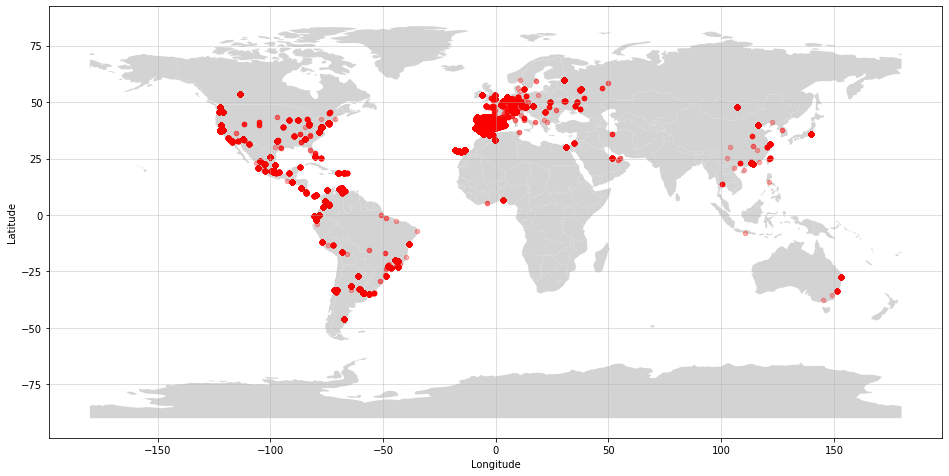

In [21]:
# Representem en un mapa la longitud i latitud de cada accés amb un punt

fig, ax = plt.subplots(figsize=(16,12))
# Pintem el mapa
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(color="lightgrey", ax=ax)

# Pintem els punts
df.plot(x="Longitude", y="Latitude", kind="scatter", 
        c="red", alpha=0.3, colormap="YlOrRd", 
        ax=ax)

# Afegim grid
ax.grid(b=True, alpha=0.5)
plt.show()

Veiem que la majoria d'accéssos provenen d'Espanya. Podem representar-ho a nivell de paisos:

In [22]:
# IP2Location utilitza un codi de 2 lletres per identificar els paisos
# Mentres que Geopandas utilitza un codi de 3 lletres
# Utilitzem el mòdul iso3166 per trobar l'equivalència

!pip install iso3166

In [23]:
from iso3166 import countries

# Treballem sobre una copia del dataframe
df2 = df.copy()

# Afegim una columna 'iso_a3' amb el codi de país de 3 lletres
# Per als casos d'accés local (NaN), deixem NaN
df2['iso_a3'] = df2.CountryShort.map(lambda x: x if pd.isnull(x) else countries.get(x).alpha3)

In [24]:
# Veiem que hi ha alguns paísos que apareixen amb codi ISO_A3 '-99'
# He buscat a Google i en alguns casos és perquè el país no està reconegut
# com a tal (Somaliland, North Cyrpus) i en altres és un bug d'aquesta base de
# dades (France, Norway, Kosovo). Corregeixo els codis manualment

world[world.iso_a3 == '-99']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. Cyprus,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,Somaliland,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [25]:
# Corregim codis ISO_A3 de France, Norway, Kosovo
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Kosovo', 'iso_a3'] = 'XXK'

In [26]:
# Afegim al Geopandas DataFrame la info del nostre dataframe (nombre de accessos)
# combinant la informació a partir del codi de pais ISO_A3
world = pd.merge(world,  df2.groupby('iso_a3').count().IP, on='iso_a3', how="outer")

world.rename(columns={'IP':'numIPAccesses'}, inplace=True)

# Substituïm els NaN per 0 en el nombre d'accessos
world.numIPAccesses.fillna(0, inplace=True)

In [27]:
world.sample(7)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,numIPAccesses
40,31304016.0,South America,Venezuela,VEN,468600.0,"POLYGON ((-60.73357 5.20028, -60.60118 4.91810...",134.0
108,18028549.0,Asia,Syria,SYR,50280.0,"POLYGON ((35.71992 32.70919, 35.70080 32.71601...",0.0
157,28036829.0,Asia,Yemen,YEM,73450.0,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",0.0
37,6172011.0,North America,El Salvador,SLV,54790.0,"POLYGON ((-89.35333 14.42413, -89.05851 14.340...",0.0
163,33986655.0,Africa,Morocco,MAR,282800.0,"POLYGON ((-2.16991 35.16840, -1.79299 34.52792...",0.0
43,67106161.0,Europe,France,FRA,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",1580.0
22,57713.0,North America,Greenland,GRL,2173.0,"POLYGON ((-46.76379 82.62796, -43.40644 83.225...",0.0


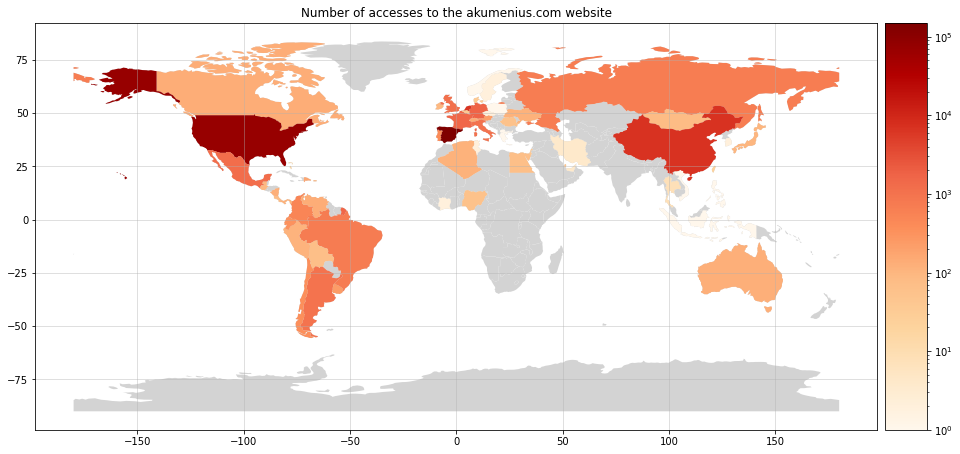

In [28]:
# Pintem cada país d'un color segons el nombre d'accessos a la web provinents
# de cada país. Utilitzem una escala logarítmica

from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(16,12))

# Mapa del món
world.plot(color="lightgrey", ax=ax)

# Barra amb la llegenda de colors
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Accessos a la web
world.plot(column='numIPAccesses', 
           legend=True, 
           ax=ax, 
           norm=colors.LogNorm(vmin=world.numIPAccesses.min()+1, 
                               vmax=world.numIPAccesses.max()),
           cmap='OrRd',
           cax=cax
           );

ax.grid(b=True, alpha=0.5)
ax.set_title('Number of accesses to the akumenius.com website')

plt.show()

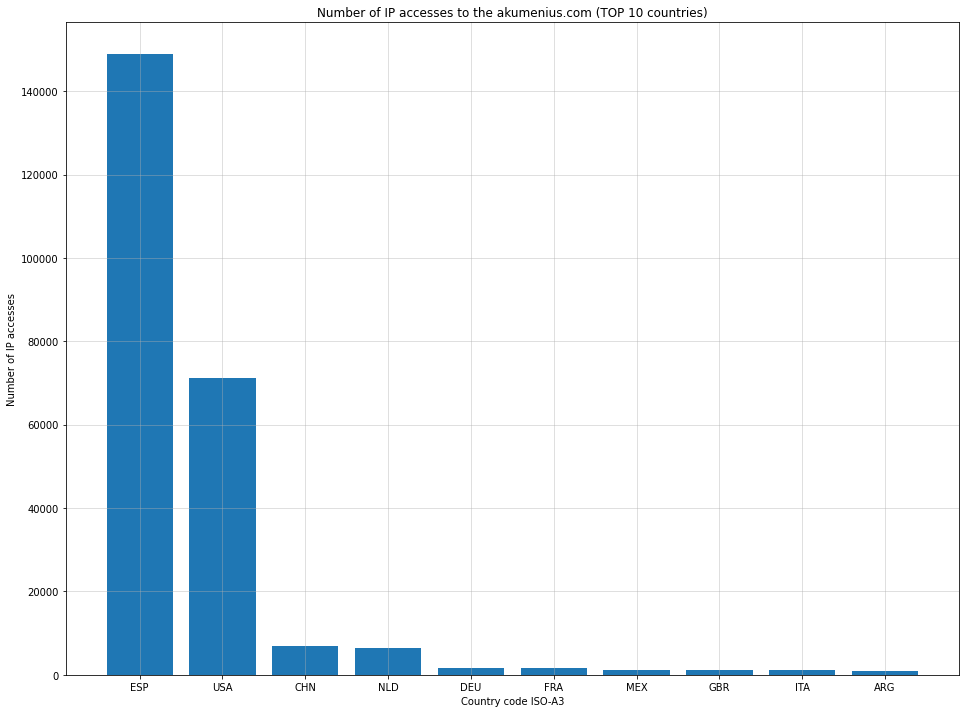

In [29]:
# Els 10 paísos amb més accessos a la web

plt.subplots(figsize=(16,12))

foo = world.sort_values('numIPAccesses', ascending=False)
foo  = foo.iloc[0:10,:]
plt.bar(foo.iso_a3, foo.numIPAccesses)
plt.grid(b=True, alpha=0.5)

plt.title('Number of IP accesses to the akumenius.com (TOP 10 countries)')
plt.xlabel('Country code ISO-A3')
plt.ylabel('Number of IP accesses')
plt.show()